In [1]:
import sys
try:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
except:
    import pip
    pip.main(['install', "--upgrade", "pip"])
    pip.main(['install', "numpy"])
    pip.main(['install', "matplotlib"])
    pip.main(['install', "ipython"])
    pip.main(['install', "jupyter"])
    pip.main(['install', "pandas"])
    import numpy as np
    import pandas as pd
    
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

## Importing the data
We use the pandas library for this. The data is split into 3 files:
- sample.csv :: Some stuff we can look at to know how the bigger and slower-to-load datafiles look like
- test.csv :: Validation data, which we use to 'grade' our model by
- train.csv :: Data we use to train our model with (to find the 'optimal' parameters)

In [2]:
data_sample = pd.read_csv('sample.csv')
data_test = pd.read_csv('test.csv')
data_train = pd.read_csv('train.csv')

cases = 1
if True:
    print("Sample")
    print(data_sample.head(cases))
    print("Test")
    print(data_test.head(cases))
    print("Train")
    print(data_train.head(cases))

Sample
    Id         y
0  900  6.055126
Test
    Id        x1        x2       x3       x4        x5        x6        x7  \
0  900  0.658913  1.489215  1.65309  2.68705  0.613798  1.599903  1.345002   

         x8       x9       x10       x11       x12       x13       x14  \
0  1.617774 -0.48859  2.893903  3.800831 -0.018902  0.857224  0.881235   

       x15  
0  0.57476  
Train
   Id           y        x1        x2        x3        x4       x5        x6  \
0   0  116.376061  1.276266 -0.854628  1.623901  2.145311  2.03719  2.886639   

         x7        x8        x9       x10       x11      x12       x13  \
0  0.888302  0.637899  1.148675  0.562217  3.171257  2.15231 -0.818812   

        x14      x15  
0  0.861951  1.53984  


The data contains 'headers' (Thing like 'Id', 'y', 'x1', 'x2', etc.). For pure data processing we need to get rid of this (because these are not numebrs), and just retrieve the numerical values within the matrices. CV stands for cross-validation. Printing the shapes is just to make sure the import was successful.

In [3]:
X_data = data_train.values
y_sample = data_sample.values
X_test = data_test.values[:,1:]

#Test data!! split training set into 80:20 and use the 80 part as training data, including cross validation. Use the last 20 percent to measure data accuracy

if True:
    print("X_train")
    print(X_data.shape)
    print("y_sample")
    print(y_sample.shape)
    print("X_finaltest")
    print(X_test.shape)

    print("And has types")
    print(type(X_test[0,0]))

X_train
(900, 17)
y_sample
(2000, 2)
X_finaltest
(2000, 15)
And has types
<type 'numpy.float64'>


## Function Definitions and Applications
Here we define the functions we will use to predict the weights (normalEq, or maybe even stochastic gradient descent), and also the given error function (rms). Trying out different algorithms and testing them through cross-validation. Look at the external files for the algorithms.

### Normal Equations without Kernel
#### with regulaizer parameters = lam
We test a total of 10000 different values for lambda in between 1e-20 and 1e10

In [4]:
from helper import *
from normalEq import *

k = 5 #number of folds for cross validation

if X_data.shape[0] % k != 0:
    print("Number of samples not divisible by k!")
    sys.exit(0)
    
print("Total samples: ", X_data.shape[0])

total_error = 0.0

X = np.split(X_data[:,2:], k, axis=0)
y = np.split(X_data[:,1], k, axis=0)

print(X[0].shape)
print(y[0].shape)

loss_dict = []
lam_dict = []

lam_range = np.logspace(-14, 10, num=10000)#[1e-8, 1e-3, 1e2]

#Apply cross validation
for lam in lam_range:
    loss = 0
    for i in range(k):
        X_train, y_train, X_cv, y_cv = get_train_cross_dataset(X, y, i)

        #apply to training function, then measure the error
        weights = reg_normal_eq(X_train, y_train, lam)
        
        ##Measure loss
        predictions = np.dot(X_cv, weights)
        loss = rms(predictions, y_cv)    
    
    total_error += loss    
    total_error /= k
    
    lam_dict.append(lam)
    loss_dict.append(total_error)    
    

('Total samples: ', 900)
(180, 15)
(180,)


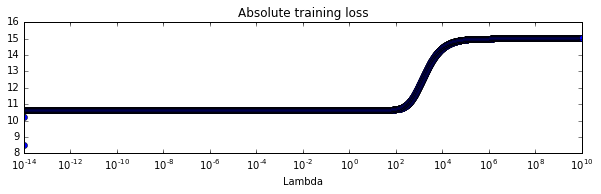

In [5]:
plt.subplot(3, 1, 1)
plt.title('Absolute training loss')
plt.xlabel('Lambda')
plt.semilogx(lam_dict, loss_dict, 'o')
#plt.plot(lam_dict, 'o', label='baseline')
#plt.plot(loss_dict, 'o', label='batchnorm')
plt.show()

In [6]:
print("The minimal error is given when lambda equals: ", lam_dict[np.argmin(loss_dict)])

('The minimal error is given when lambda equals: ', 1e-14)


### Normal Equations with polynomial Kernel of degree d = 2
#### with regulaizer parameters = lam
We test a total of 10000 different values for lambda in between 1e-20 and 1e10

In [7]:
from helper import *
from normalEq import *

k = 5 #number of folds for cross validation

if X_data.shape[0] % k != 0:
    print("Number of samples not divisible by k!")
    sys.exit(0)
    
print("Total samples: ", X_data.shape[0])

total_error = 0.0

X = np.split(X_data[:,2:], k, axis=0)
y = np.split(X_data[:,1], k, axis=0)

print(X[0].shape)
print(y[0].shape)

loss_dict = []
lam_dict = []

lam_range = np.logspace(-12, 2, num=1039)#[1e-8, 1e-3, 1e2] #we choose a prime number

old_loss = 1000000 #so the first best number gets chosen
#Apply cross validation
for lam in lam_range:
    loss = 0
    for i in range(k):
        X_train, y_train, X_cv, y_cv = get_train_cross_dataset(X, y, i)
        
        #pass X_train and X_cv through the kernel function first!
        X_train = poly2d_kernel(X_train)
        X_cv = poly2d_kernel(X_cv)
        

        #apply to training function, then measure the error
        weights = reg_normal_eq(X_train, y_train, lam)
        
        ##Measure loss
        predictions = np.dot(X_cv, weights)
        loss = rms(predictions, y_cv)    
        
        if loss < old_loss:
            best_weights = weights
    
    total_error += loss    
    total_error /= k
       
    lam_dict.append(lam)
    loss_dict.append(total_error)    
    
print best_weights    

('Total samples: ', 900)
(180, 15)
(180,)
[  0.90460562   4.65287502  -0.0279272   12.87101385   0.34317465
  -7.68011663   1.96429383  -7.6998417  -10.65471107   2.1362937
  13.70728466   5.17852314  -3.10881375   4.13160734  -8.82775132
  -1.28029966   0.          -1.93071981  -0.85907355   0.28756239
  -2.42863184  -4.76884707  -3.21853158  -1.11405591   2.09939102
   4.57509171  -1.80177964  -1.92027426  -1.23853536  -0.32320334
  -3.44530746  -1.44172297   5.31990714  -1.78102974   0.61252786
   4.63934612  -1.59078874  -7.40249735   4.09162884   7.40767801
   3.77809478   2.32941755   0.90060905  -1.83203613   0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.      

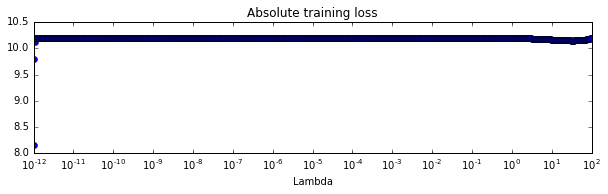

In [8]:
plt.subplot(3, 1, 1)
plt.title('Absolute training loss')
plt.xlabel('Lambda')
plt.semilogx(lam_dict, loss_dict, 'o')
#plt.plot(lam_dict, 'o', label='baseline')
#plt.plot(loss_dict, 'o', label='batchnorm')
plt.show()

In [9]:
print("The minimal error is given when lambda equals: ", lam_dict[np.argmin(loss_dict)])

('The minimal error is given when lambda equals: ', 9.9999999999999998e-13)


### Normal Equations with polynomial Kernel of degree d = 3
#### with regulaizer parameters = lam
We test a total of 10000 different values for lambda in between 1e-20 and 1e10

In [10]:
from helper import *
from normalEq import *

k = 5 #number of folds for cross validation

if X_data.shape[0] % k != 0:
    print("Number of samples not divisible by k!")
    sys.exit(0)
    
print("Total samples: ", X_data.shape[0])

total_error = 0.0

X = np.split(X_data[:,2:], k, axis=0)
y = np.split(X_data[:,1], k, axis=0)

print(X[0].shape)
print(y[0].shape)

loss_dict = []
lam_dict = []

#lam_range = np.logspace(-5, 5, num=317)#[1e-8, 1e-3, 1e2] #we choose a prime number
lam_range = np.logspace(-16, -12, num=101)
lam_range = np.logspace(0.2, 4.5, num=101)
lam_range = np.logspace(-16, 8, num=1999)

old_loss = 1000000 #so the first best number gets chosen
#Apply cross validation
for lam in lam_range:
    loss = 0
    for i in range(k):
        X_train, y_train, X_cv, y_cv = get_train_cross_dataset(X, y, i)
        
        #pass X_train and X_cv through the kernel function first!
        X_train = poly3d_kernel(X_train)
        X_cv = poly3d_kernel(X_cv)
        

        #apply to training function, then measure the error
        weights = reg_normal_eq(X_train, y_train, lam)
        
        ##Measure loss
        predictions = np.dot(X_cv, weights)
        loss = rms(predictions, y_cv)    
        
        if loss < old_loss:
            best_weights = weights
    
    total_error += loss    
    total_error /= k
       
    lam_dict.append(lam)
    loss_dict.append(total_error)    
    
#print best_weights    

('Total samples: ', 900)
(180, 15)
(180,)


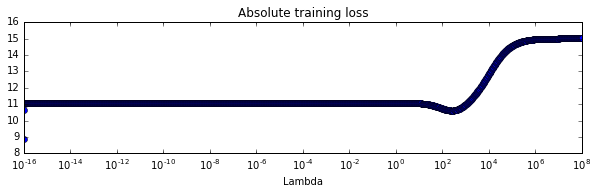

In [11]:
plt.subplot(3, 1, 1)
plt.title('Absolute training loss')
plt.xlabel('Lambda')
plt.semilogx(lam_dict, loss_dict, 'o')
#plt.plot(lam_dict, 'o', label='baseline')
#plt.plot(loss_dict, 'o', label='batchnorm')
plt.show()

In [12]:
print("The minimal error is given when lambda equals: ", lam_dict[np.argmin(loss_dict)])

('The minimal error is given when lambda equals: ', 9.9999999999999998e-17)


In [13]:
print("Minimal loss", min(loss_dict))
index = np.argmin(loss_dict)
indecies = np.argsort(loss_dict)[::-1][-50:][::-1]
print("Minimizing lr and mu: ", lam_dict[index])
for i in range(50):
    print("Loss: " + str(loss_dict[indecies[i]]) + ", lam: " + str(lam_dict[indecies[i]]))

('Minimal loss', 8.8659084097011149)
('Minimizing lr and mu: ', 9.9999999999999998e-17)
Loss: 8.8659084097, lam: 1e-16
Loss: 10.613534122, lam: 252.582002696
Loss: 10.6136182437, lam: 259.665597293
Loss: 10.61373658, lam: 245.691646298
Loss: 10.6139939643, lam: 266.947849403
Loss: 10.614220322, lam: 238.989256623
Loss: 10.6146660159, lam: 274.434330323
Loss: 10.6149797878, lam: 232.469705999
Loss: 10.6156388333, lam: 282.130767594
Loss: 10.6160091649, lam: 226.128006634
Loss: 10.6169165451, lam: 290.043049386
Loss: 10.6173024011, lam: 219.959306803
Loss: 10.6185029651, lam: 298.177229002
Loss: 10.6188532187, lam: 213.958887134
Loss: 10.6204015852, lam: 306.539529506
Loss: 10.6206551283, lam: 208.122156999
Loss: 10.6226155694, lam: 315.136348487
Loss: 10.6227014428, lam: 202.444650998
Loss: 10.6249852932, lam: 196.922025548
Loss: 10.6251477482, lam: 323.974262953
Loss: 10.6274996428, lam: 191.550055557
Loss: 10.6280006149, lam: 333.060034362
Loss: 10.630237303, lam: 186.324631193
Loss: 

Good results for: 
    lam = 31.62277
    lam = 1.58
    lam = 

One final, very focused search within a small range

In [14]:
from helper import *
from normalEq import *

k = 5 #number of folds for cross validation

if X_data.shape[0] % k != 0:
    print("Number of samples not divisible by k!")
    sys.exit(0)
    
print("Total samples: ", X_data.shape[0])

total_error = 0.0

X = np.split(X_data[:,2:], k, axis=0)
y = np.split(X_data[:,1], k, axis=0)

print(X[0].shape)
print(y[0].shape)

loss_dict = []
lam_dict = []

#lam_range = np.logspace(-5, 5, num=317)#[1e-8, 1e-3, 1e2] #we choose a prime number
lam_range = np.logspace(-16, -12, num=101)
lam_range = np.logspace(0.2, 4.5, num=101)
lam_range = np.logspace(2, 3, num=101)

old_loss = 1000000 #so the first best number gets chosen
#Apply cross validation
for lam in lam_range:
    loss = 0
    for i in range(k):
        X_train, y_train, X_cv, y_cv = get_train_cross_dataset(X, y, i)
        
        #pass X_train and X_cv through the kernel function first!
        X_train = poly3d_kernel(X_train)
        X_cv = poly3d_kernel(X_cv)
        

        #apply to training function, then measure the error
        weights = reg_normal_eq(X_train, y_train, lam)
        
        ##Measure loss
        predictions = np.dot(X_cv, weights)
        loss = rms(predictions, y_cv)    
        
        if loss < old_loss:
            best_weights = weights
    
    total_error += loss    
    total_error /= k
       
    lam_dict.append(lam)
    loss_dict.append(total_error)    
    
#print best_weights    

('Total samples: ', 900)
(180, 15)
(180,)


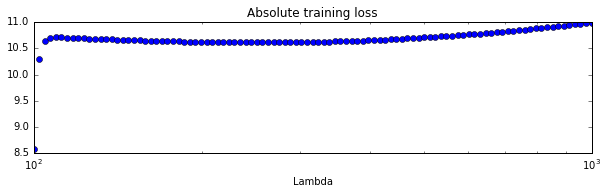

In [15]:
plt.subplot(3, 1, 1)
plt.title('Absolute training loss')
plt.xlabel('Lambda')
plt.semilogx(lam_dict, loss_dict, 'o')
#plt.plot(lam_dict, 'o', label='baseline')
#plt.plot(loss_dict, 'o', label='batchnorm')
plt.show()

In [18]:
print("Minimal loss", min(loss_dict))
index = np.argmin(loss_dict)
indecies = np.argsort(loss_dict)[::-1][-20:][::-1]
print("Minimizing lr and mu: ", lam_dict[index])
for i in range(20):
    print("Loss: " + str(loss_dict[indecies[i]]) + ", lam: " + str(lam_dict[indecies[i]]))

('Minimal loss', 8.5863388641780496)
('Minimizing lr and mu: ', 100.0)
Loss: 8.58633886418, lam: 100.0
Loss: 10.2997881779, lam: 102.329299228
Loss: 10.6135336643, lam: 251.188643151
Loss: 10.6135453328, lam: 257.039578277
Loss: 10.6137200576, lam: 245.470891569
Loss: 10.6137579988, lam: 263.02679919
Loss: 10.614101445, lam: 239.883291902
Loss: 10.6141744615, lam: 269.153480393
Loss: 10.6146746317, lam: 234.422881532
Loss: 10.6147973799, lam: 275.422870334
Loss: 10.6154363008, lam: 229.086765277
Loss: 10.6156292685, lam: 281.838293126
Loss: 10.6163830177, lam: 223.872113857
Loss: 10.616672494, lam: 288.403150313
Loss: 10.6175112366, lam: 218.776162395
Loss: 10.6179292716, lam: 295.120922667
Loss: 10.6188173047, lam: 213.79620895
Loss: 10.6194016629, lam: 301.99517204
Loss: 10.620297469, lam: 208.929613085
Loss: 10.6210915722, lam: 309.029543251


Final evaluation: Which lambda is the best?

In [20]:
from helper import *
from normalEq import * 

X_train, y_train, X_cv, y_cv = get_train_cross_dataset(X, y, 0)

for lam in [102.329299228, 251.188643151]:
    loss = 0
    for i in range(k):
        X_train, y_train, X_cv, y_cv = get_train_cross_dataset(X, y, i)
        
        #pass X_train and X_cv through the kernel function first!
        X_train = poly3d_kernel(X_train)
        X_cv = poly3d_kernel(X_cv)
        

        #apply to training function, then measure the error
        weights = reg_normal_eq(X_train, y_train, lam)
        
        ##Measure loss
        predictions = np.dot(X_cv, weights)
        loss = rms(predictions, y_cv)    
        
        if loss < old_loss:
            best_weights = weights
    
    total_error += loss    
    total_error /= k
    print("Lambda: ", lam, " Loss: ", total_error)


('Lambda: ', 102.329299228, ' Loss: ', 10.711926460520825)
('Lambda: ', 251.188643151, ' Loss: ', 10.633174944919677)


## Bring the function into the submission format: Post-Processing
We have trained the weights using the training data (X_train). Remember that the sample submission data looks like the following. That means we need to predict for the test data.

In [4]:
if False:
    print("Sample")
    print(data_sample.head(cases))
    print(data_sample.tail(cases))
    print("Test")
    print(data_test.head(cases))
    print(data_test.tail(cases))
    print(X_finaltest.shape)
    print(weights.shape)
    print(y_pred_test.shape)
    print(y_pred_test)

In [6]:
from helper import *
from normalEq import *

X = poly3d_kernel(X_data[:,2:])
y = X_data[:,1]
weights = reg_normal_eq(X, y, 251.188643151)

X_sub = poly3d_kernel(X_test)

y_pred_test = np.dot(X_sub, weights)
sub_data = np.column_stack((data_test.values[:,0], y_pred_test))
print(sub_data.shape)
print(sub_data)

(2000, 2)
[[  900.            53.49228872]
 [  901.            27.3390026 ]
 [  902.            -9.98899448]
 ..., 
 [ 2897.            17.69077445]
 [ 2898.            28.63786021]
 [ 2899.            39.01257638]]


In [7]:
#pd.set_option('max_info_rows', 11)
#pd.set_option('precision',20)
submission = pd.DataFrame(sub_data, columns = ["Id", "y"])
submission.Id = submission.Id.astype(int)
print(submission)

        Id           y
0      900   53.492289
1      901   27.339003
2      902   -9.988994
3      903  -21.773733
4      904    6.711756
5      905  -37.203606
6      906   69.536275
7      907   14.449010
8      908   35.003231
9      909  144.163952
10     910  -18.813980
11     911  -77.307395
12     912    4.818249
13     913  -13.274296
14     914   35.360832
15     915   35.466325
16     916  -10.843638
17     917  -99.292618
18     918   56.940347
19     919  -19.994224
20     920   91.719123
21     921   79.567530
22     922   73.920691
23     923   22.969027
24     924   -6.228230
25     925   11.995506
26     926    4.839270
27     927  -17.682200
28     928  -23.646234
29     929  -22.457698
...    ...         ...
1970  2870    4.421983
1971  2871   21.132255
1972  2872   25.513626
1973  2873    8.071692
1974  2874    1.285401
1975  2875   -6.729717
1976  2876   66.649099
1977  2877   31.062332
1978  2878  -52.090013
1979  2879  -42.572250
1980  2880   53.325136
1981  2881 

In [8]:
csv_file = submission.to_csv('submission.csv')

## Gradient Descent

### Gradient Descent without Kernel

First of all, let's check if gradient descent actually works

In [16]:
from helper import *
from sgd import *

lr = 0.1
mu = 0.1

w = np.random.normal(0.0, 1.0, size=(X_train.shape[1])) #must be adaptable to X

train_loss_list, cv_loss_list, w = run_sgd(X[0], y[0], X[1], y[1], w, mu, lr, rms, MAX_STEPS=20, batch_size=20)

print(train_loss_list)
print(cv_loss_list)


[51.965120872234081, 45.034856117168871, 39.923536147476511, 36.063201985223685, 33.065500280474332, 30.715866762972631, 28.843115849635634, 27.334242629321373, 26.102238350182638, 25.085663238951142, 24.237925320308019, 23.524637847582845, 22.919451251220874, 22.402200956476747, 21.957107658112925, 21.571735477952924, 21.23614206508886, 20.942313693662758, 20.683728647192357, 20.455042730609794]
[66.117207899462741, 60.726139618107055, 59.889497154708643, 58.064781784497043, 57.350867874123608, 56.572031693087808, 56.117171618614059, 55.7225420050911, 55.445139892726701, 55.218778490415723, 55.044532579618178, 54.902231358680986, 54.786812874376011, 54.690475170563339, 54.609341841454636, 54.539717675210355, 54.479188981008043, 54.425761325111793, 54.377976070581695, 54.334673022647884]


Seems fine, as all loss values decrese

In [17]:
from helper import *
from sgd import *

k = 5 #number of folds for cross validation

if X_data.shape[0] % k != 0:
    print("Number of samples not divisible by k!")
    sys.exit(0)
    
print("Total samples: ", X_data.shape[0])

total_error = 0.0

X = np.split(X_data[:,2:], k, axis=0)
y = np.split(X_data[:,1], k, axis=0)

print(X[0].shape)
print(y[0].shape)

loss_dict = []
#lr_dict = []
#mu_dict = []
para_dict = []

#lr_range = np.logspace(-1.150, -1.100, num=20)
lr_range = np.linspace(0.0848, 0.0850, num=20)
#mu_range = np.logspace(-10, -8, num=10)
mu_range = np.linspace(1.00e-10, 1.50e-10, num=20)

#Apply cross validation
for lr in lr_range:
    for mu in mu_range:
        
        #Initialize everything
        w = np.random.normal(0.0, 1.0, size=(X_train.shape[1])) #must be adaptable to X

        
        total_error = 0
         
        for i in range(k):
            X_train, y_train, X_cv, y_cv = get_train_cross_dataset(X, y, i)
            
            #use dictionary as input instead of direct parameters maybe
            train_loss_dict, cv_loss_dict, w = run_sgd(
                                                        X_train=X_train, 
                                                        y_train=y_train,
                                                        X_cv=X_cv, 
                                                        y_cv=y_cv,
                                                        w=w, 
                                                        mu=mu, 
                                                        lr=lr, 
                                                        fn_loss=rms, 
                                                        MAX_STEPS=100
                                                        )    
            ##Measure loss
            loss = cv_loss_dict[-1] #last one describes the achieved loss
            total_error += loss
            
            
        total_error /= k
        
        #lr_dict.append(lr)
        #mu_dict.append(mu)
        print((lr, mu, total_error))
        para_dict.append((lr, mu))
        loss_dict.append(total_error)  

#print(lr_dict)
#print(mu_dict)
#print(loss_dict)
    

('Total samples: ', 900)
(180, 15)
(180,)
(0.0848, 1e-10, 47.27974861009087)
(0.0848, 1.0263157894736842e-10, 44.985030701958564)
(0.0848, 1.0526315789473684e-10, 45.499723784325866)
(0.0848, 1.0789473684210527e-10, 46.62820187910993)
(0.0848, 1.1052631578947369e-10, 46.910527914760905)
(0.0848, 1.1315789473684211e-10, 46.473305224028515)
(0.0848, 1.1578947368421053e-10, 46.664280768138148)
(0.0848, 1.1842105263157895e-10, 48.321728308839674)
(0.0848, 1.2105263157894737e-10, 45.073283342194536)
(0.0848, 1.2368421052631579e-10, 46.284067414309618)
(0.0848, 1.263157894736842e-10, 48.525630130411834)
(0.0848, 1.2894736842105262e-10, 45.76230274207397)
(0.0848, 1.3157894736842104e-10, 48.13365337181564)
(0.0848, 1.3421052631578949e-10, 46.909722842705044)
(0.0848, 1.3684210526315788e-10, 46.233590288031976)
(0.0848, 1.3947368421052632e-10, 45.892454707434332)
(0.0848, 1.4210526315789474e-10, 45.306919479738497)
(0.0848, 1.4473684210526316e-10, 47.794425685280927)
(0.0848, 1.473684210526315

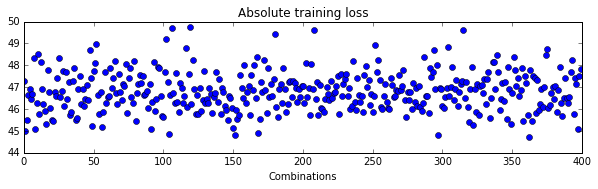

In [18]:
plt.subplot(3, 1, 1)
plt.title('Absolute training loss')
plt.xlabel('Combinations')
plt.plot(loss_dict, 'o')
#plt.plot(lam_dict, 'o', label='baseline')
#plt.plot(loss_dict, 'o', label='batchnorm')
plt.show()

In [19]:
print("Minimal loss", min(loss_dict))
index = np.argmin(loss_dict)
indecies = np.argsort(loss_dict)[-10:]
print("Minimizing lr and mu: ", para_dict[index])
for i in range(10):
    print("Loss: " + str(loss_dict[indecies[i]]) + ", lr and mu: " + str(para_dict[indecies[i]]))

('Minimal loss', 44.709527570774526)
('Minimizing lr and mu: ', (0.084989473684210531, 1.0526315789473684e-10))
Loss: 48.7973427667, lr and mu: (0.084852631578947374, 1.4210526315789474e-10)
Loss: 48.8324151628, lr and mu: (0.084957894736842107, 1.1052631578947369e-10)
Loss: 48.9121895889, lr and mu: (0.084926315789473683, 1.3157894736842104e-10)
Loss: 48.9724365392, lr and mu: (0.08482105263157895, 1.3157894736842104e-10)
Loss: 49.2109379277, lr and mu: (0.084852631578947374, 1.0526315789473684e-10)
Loss: 49.4115533521, lr and mu: (0.084894736842105273, 1e-10)
Loss: 49.5962616099, lr and mu: (0.084905263157894734, 1.2105263157894737e-10)
Loss: 49.6116938009, lr and mu: (0.084957894736842107, 1.3947368421052632e-10)
Loss: 49.7028766859, lr and mu: (0.084852631578947374, 1.1578947368421053e-10)
Loss: 49.7489799979, lr and mu: (0.084852631578947374, 1.5e-10)


#### Training Error vs CV Error

In [20]:
STEPS = 10000
lr = 0.084926315789473683
mu = 1.3157894736842104e-10

w = np.random.normal(0.0, 1.0, size=(X_train.shape[1])) #must be adaptable to X

train_loss_dict, cv_loss_dict, w = run_sgd(
                                            X_train=X_train, 
                                            y_train=y_train,
                                            X_cv=X_cv, 
                                            y_cv=y_cv,
                                            w=w, 
                                            mu=mu, 
                                            lr=lr, 
                                            fn_loss=rms, 
                                            MAX_STEPS=10000
                                        )

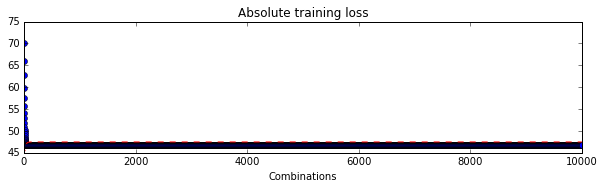

In [21]:
#Show plot CV error vs training error
plt.subplot(3, 1, 1)
plt.title('Absolute training loss')
plt.xlabel('Combinations')
plt.plot(np.arange(STEPS), train_loss_dict, 'o', np.arange(STEPS), cv_loss_dict, 'r--')

plt.show()

### Gradient Descent with polynomial Kernel of degree d = 2

## Bring the function into the submission format: Post-Processing
We have trained the weights using the training data (X_train). Remember that the sample submission data looks like the following. That means we need to predict for the test data.

In [9]:
if False:
    print("Sample")
    print(data_sample.head(cases))
    print(data_sample.tail(cases))
    print("Test")
    print(data_test.head(cases))
    print(data_test.tail(cases))
    print(X_finaltest.shape)
    print(weights.shape)
    print(y_pred_test.shape)
    print(y_pred_test)

First of all, calculate the predictions. Don't forget to stack a bias column. The submission format includes the ID's taken from the X-training data. Each invidual record has a predicted 'y' record aswell.

In [10]:
y_pred_test = np.dot(np.column_stack((X_finaltest, np.ones(X_finaltest.shape[0]))), weights)
sub_data = np.column_stack((data_test.values[:,0], y_pred_test))
print(sub_data.shape)
print(sub_data)

ValueError: shapes (2000,11) and (10,) not aligned: 11 (dim 1) != 10 (dim 0)

This look alright... Let's wrap it in a pandas-dataframe (that's what the datastructures including the headers with 'ID' and 'y' are called)

In [78]:
pd.set_option('max_info_rows', 11)
pd.set_option('precision',20)
submission = pd.DataFrame(sub_data, columns = ["Id", "y"])
submission.Id = submission.Id.astype(int)
print(submission)

         Id                         y
0     10000  -66.00242349023130827845
1     10001  451.40650440115518904349
2     10002 -461.67641706029962733737
3     10003   40.50120875372320483621
4     10004 -126.74472245403632086891
5     10005 -342.53455181925158967715
6     10006 -396.55554211359054761488
7     10007  335.54127907908764427702
8     10008  -99.51242087062264829456
9     10009  304.81253980627650435054
10    10010   68.89453048978556637394
11    10011  412.36919545590848201755
12    10012   54.94237102476856193789
13    10013  -17.00555075478039768200
14    10014 -597.84995757226056412037
15    10015  443.50228878641490837254
16    10016  144.77448697804288713087
17    10017  -57.41116367253620467181
18    10018  134.38782757746042761937
19    10019 -108.98377598910846586477
20    10020  153.82482842506630049684
21    10021  611.73598360220182712510
22    10022  588.38965033842225693661
23    10023 -131.01679995802052758336
24    10024  -61.13562114123003965460
25    10025 

*** I'M NOT SURE IF IT HAS TO BE 1-point PRECISION (last record to be 417.3, instead of 417.269155). ***

Not let's export the submission file as a csv

In [14]:
csv_file = submission.to_csv('final_submission.csv')